# Finding Heavy Traffic Indicators on I-94 Guided Project

This project will focus on applying data visualization knowledge using matplotlib and seaborn to analyze a traffic dataset for correlations of traffic heaviness and other variables.

The dataset used here contains 2012-2018 westbound [I-94 highway](https://en.wikipedia.org/wiki/Interstate_94) traffic, was compiled by [John Hogue](john.d.hogue@live.com) of General Mills and Social Data Science, and can be found [here](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume). Traffic data is captured on the hour from the automatic traffic recorder (ATR) station 301 that is located roughly between Minneapolis and St Paul, MN. See the following map of the location:

![Station_301_Region](station_301_region.png)

Deviations from Dataquest's instructions are not always noted within the notebook, but steps are made to go beyond the focus of the project.

Sections:

[0.0 Importing Data, Quick Peek](#0.0-Importing-Data,-Quick-Peek) <br>

[2.0 Data Exploration](#2.0-Data-Exploration) <br>
[2.1 Traffic Distribution](#2.1-Traffic-Distribution) <br>
[2.2 Investigating Time of Day](#2.2-Investigating-Time-of-Day) <br>
[2.3 Variables Affecting Day Time Traffic](#2.3-Variables-Affecting-Day-Time-Traffic) <br>

---

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sbn

## 0.0 Importing Data, Quick Peek

In [2]:
traffic = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

In [3]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


Fortunately there are no null values, and data with just another quick look at the data, we can determine whether/how much cleaning is necessary.

In [4]:
traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


- The **holiday** column describes a US national holiday or a regional holiday (ie in Minnesota), and is described from the repo as categorical, but it's not clear what this data looks like based on the above
- Temperature (**temp**) is in Kelvin
- It's not entirely clear what **clouds_all** refers to without the legend from the dataset repository, but the numbers here are percentages. The column name will be updated to reflect this:

In [5]:
traffic.rename(columns={'clouds_all':'clouds_percent'}, inplace=True)

Next just perform a quick check of the **holiday** data to see how it looks:

In [6]:
traffic['holiday'].value_counts()

None                         48143
Labor Day                        7
Thanksgiving Day                 6
New Years Day                    6
Christmas Day                    6
Martin Luther King Jr Day        6
Veterans Day                     5
Columbus Day                     5
Independence Day                 5
Memorial Day                     5
Washingtons Birthday             5
State Fair                       5
Name: holiday, dtype: int64

Ok, so there are several holidays occurring within the dates surveyed. Curiously there are less than 24 hours per holiday identified in the **holiday** column... Given the 2012-2018 data survey, it seems that the holiday column may identify the occurrence of a holiday once per year rather than 24 times per year. FIXME: for more investigation.

## 2.0 Data Exploration

### 2.1 Traffic Distribution

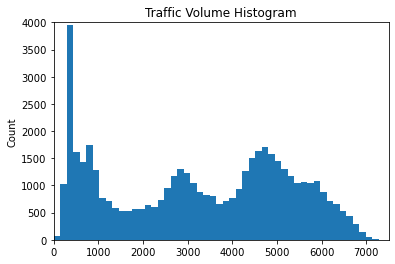

In [93]:
plt.hist(traffic['traffic_volume'],bins=50)
plt.xlim([0,7500])
plt.ylim([0,4000])
plt.ylabel('Count')
plt.title('Traffic Volume Histogram')
plt.show()

Clearly the distribution is at least trimodal with peaks around:
- 500, little to no traffic
- 3000. I am not yet certain what this is. I believe it may be weekend commuter traffic, weekday traffic reduced by weather and/or season, or, though unlikely, holiday traffic.
- 5000 and above. This is likely weekday heavy traffic from commuters due to the high frequency 

We will probably investigate all of these.

### 2.2 Investigating Time of Day

Of the many variables that influence the traffic distribution, time of day is one that we can look at. We will simply split the 24-hour period to identify day and night as follows:
- Day is from 7am to 7pm
- Night is from 7pm to 7am

So let's start by spliting the data in this fashion. In order to do this, first convert the **date_time** values to datetime objects:

In [21]:
traffic['date_time'] = pd.to_datetime(traffic['date_time'])

In [67]:
# Now split the data

day_time = traffic[traffic['date_time'].dt.hour.between(6,19,inclusive=False)]
night_time = traffic[~traffic['date_time'].dt.hour.between(6,19,inclusive=False)]

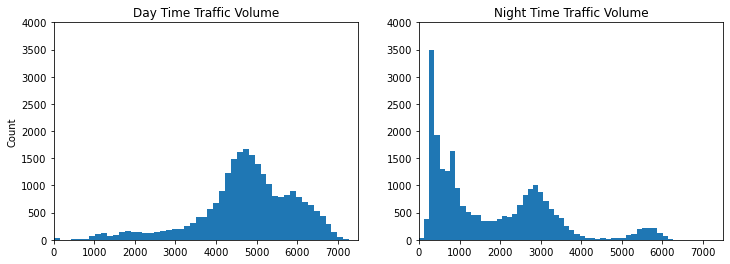

In [72]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(day_time['traffic_volume'],bins=50)
plt.xlim([0,7500])
plt.ylim([0,4000])
plt.ylabel('Count')
plt.title('Day Time Traffic Volume')
plt.subplot(1,2,2)
plt.hist(night_time['traffic_volume'],bins=50)
plt.xlim([0,7500])
plt.ylim([0,4000])
plt.title('Night Time Traffic Volume')
plt.show()

In [83]:
day_night_comp = pd.DataFrame({'Day Traffic Volume':day_time['traffic_volume'].describe(),
                              'Night Traffic Volume':night_time['traffic_volume'].describe()})
day_night_comp

,Day Traffic Volume,Night Traffic Volume
count,23877.000000,24327.000000
mean,4762.047452,1785.377441
std,1174.546482,1441.951197
min,0.000000,0.000000
25%,4252.000000,530.000000
50%,4820.000000,1287.000000
75%,5559.000000,2819.000000
max,7280.000000,6386.000000


Clearly the latter peak around 5000 is from day time driving (as it has been defined here). This peak itself appears to be made up of one centered on 5000, and another centered on 6000. The 6000 traffic volume bump is present in both day and night time driving and may heavy traffic due to car accidents or road work that may be occurring at any time of day.

Covneniently, the 0 and 3000 traffic volume peaks are present in only the night time driving histogram. Again, it is not entirely clear what the 3000 histogram peak refers to, but perhaps this is simply night work commuters. Let's do a simple check of this by further narrowing the night time data to 9pm to 3am:

In [95]:
midnight_run = traffic[~traffic['date_time'].dt.hour.between(3,21,inclusive=False)]
evening_commuters = traffic[traffic['date_time'].dt.hour.between(4,6,inclusive=True) |
                            traffic['date_time'].dt.hour.between(19,20,inclusive=True)]

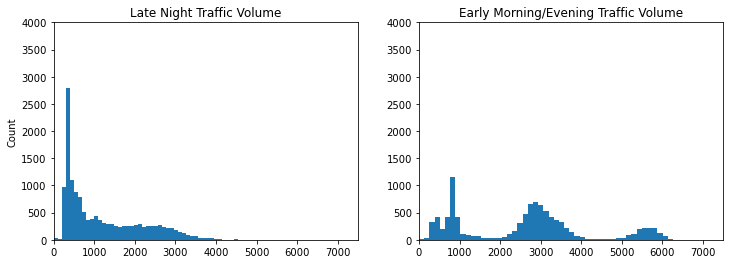

In [99]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(midnight_run['traffic_volume'],bins=50)
plt.xlim([0,7500])
plt.ylim([0,4000])
plt.ylabel('Count')
plt.title('Late Night Traffic Volume')
plt.subplot(1,2,2)
plt.hist(evening_commuters['traffic_volume'],bins=50)
plt.xlim([0,7500])
plt.ylim([0,4000])
plt.title('Early Morning/Evening Traffic Volume')
plt.show()

Indeed, the late night distribution is roughly decreasing towards higher traffic volumes. So isolating the early evening/morning times left out by this distribution does highlight the 3000 traffic volume peak.

However, the ~6000 peak is absent in the late night distribution, somewhat contradicting the assertion that this peak is caused by accidents and/or road work. While this may be true, it is also possible that reduced load of traffic on the highway does cause traffic to build up (a question of traffic dynamics that I do not know the exact specifics of).

Back to the task at hand of identifying indicators of heavy traffic, we should primarily focus on the daytime distribution isnce it contains the main high traffic peak around 5000. We will therefore continue with the day_time data only.

### 2.3 Variables Affecting Day Time Traffic

We will specifically focus on how the month of year, day of week, and time of day affcet day time traffic. In doing so, we will explicitly add these variables to the dataset. Start with month:

In [100]:
day_time['month'] = day_time['date_time'].dt.month
by_month = day_time.groupby('month').mean()
by_month['traffic_volume']

<ipython-input-100-0d0913a858f7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_time['month'] = day_time['date_time'].dt.month


month
1     4495.613727
2     4711.198394
3     4889.409560
4     4906.894305
5     4911.121609
6     4898.019566
7     4595.035744
8     4928.302035
9     4870.783145
10    4921.234922
11    4704.094319
12    4374.834566
Name: traffic_volume, dtype: float64

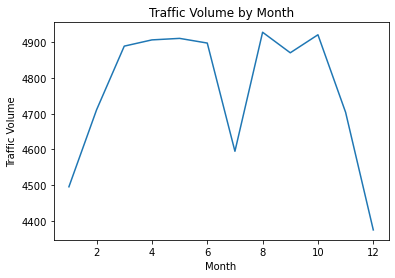

In [106]:
plt.plot(by_month['traffic_volume'])
plt.xlabel('Month')
plt.ylabel('Traffic Volume')
plt.title('Traffic Volume by Month')
plt.show()

So the traffic appears to increase during the summer/warmer months, with an odd exception of July when the traffic drops by 4600/4900 $\approx$ 7% compared to months before and after. Apparently there was [road work](https://www.mlive.com/news/ann-arbor/2016/06/road_construction_projects_tha.html) on I-94 in July of 2016.

Now move to day of week:

<ipython-input-108-82a6510d8c48>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_time['day_of_week'] = day_time['date_time'].dt.dayofweek


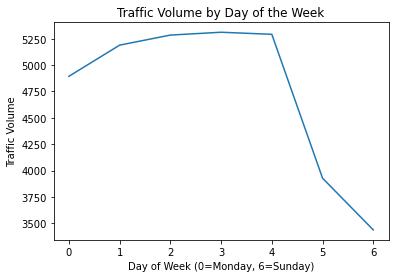

In [108]:
day_time['day_of_week'] = day_time['date_time'].dt.dayofweek
by_weekday = day_time.groupby('day_of_week').mean()
by_weekday['traffic_volume']

plt.plot(by_weekday['traffic_volume'])
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Traffic Volume')
plt.title('Traffic Volume by Day of the Week')
plt.show()

Unsurprisingly traffic is minimal on Sunday, maximal on weekdays, and somewhat on minimal when people are going places to take advantage of time off from the traditional work week.

Lastly, look at time of day AFTER splitting work days and weekend days:

<ipython-input-110-e4846d6d2a5b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_time['hour'] = day_time['date_time'].dt.hour


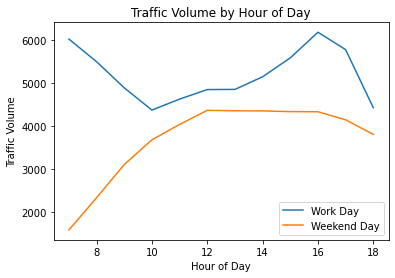

In [110]:
day_time['hour'] = day_time['date_time'].dt.hour

business_days = day_time[day_time['day_of_week'] <= 4]
by_hour_business = business_days.groupby('hour').mean()

weekend = day_time[day_time['day_of_week'] > 4]
by_hour_weekend = weekend.groupby('hour').mean()

plt.plot(by_hour_business['traffic_volume'],label='Work Day')
plt.plot(by_hour_weekend['traffic_volume'],label='Weekend Day')
plt.legend()
plt.xlabel('Hour of Day')
plt.ylabel('Traffic Volume')
plt.title('Traffic Volume by Hour of Day')
plt.show()

Again, not particularly surprising, but I guess it does support some basic hypotheses of when traffic is heavy. Morning and evening commutes on work days, and generally throughout midday on weekends are worst.